In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from warnings import filterwarnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data as data_utils
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm

import graphviz
import hiddenlayer as hl

filterwarnings('ignore')

1. Our date here is csv file

In [44]:
df = pd.read_csv('./data/regresion_data.csv')
df = df.drop(columns='Unnamed: 0')
# there is no frq if there are no aerodnamic circuit => 
# => if label != 1.
# then
index_names = df[(df['label'] == 0)].index
df.drop(index_names, inplace = True)
# Also, after that segregation by the label, we can drop label column
df = df.drop(columns='label')
print(df.head(10))

   axial_max   tang_max  index_of_axm  index_of_tnm  axial_in_mxt   
0 -16.549675 -17.654378            28            48    -10.975493  \
1 -16.564726 -17.815883            28            52    -14.410172   
2 -16.335568 -17.578816            28            50    -12.664116   
3 -15.968865 -17.108087            28            47    -10.236513   
4 -15.227270 -16.266240            28            49    -12.056063   
5 -14.682051 -15.377140            27            51    -13.252567   
6 -14.086215 -14.515554            27            50    -12.391912   
7 -13.962619 -13.729980            28            45     -9.941273   
8 -13.620183 -13.183838            27            44     -9.637045   
9 -12.883969 -11.235115            24            41     -8.141471   

   tang_in_mxa  cone_angl   frequancy  
0   -16.597827          4  126.984123  
1   -16.724255          4  126.984123  
2   -16.415995          4  125.152626  
3   -15.878571          4  120.879120  
4   -15.246275          4  114.774117  


In [45]:
df.corr()

,axial_max,tang_max,index_of_axm,index_of_tnm,axial_in_mxt,tang_in_mxa,cone_angl,frequancy
axial_max,1.000000,0.900749,-0.729426,-0.752424,0.602443,0.899512,0.213329,-0.883728
tang_max,0.900749,1.000000,-0.804928,-0.780352,0.524339,0.979297,0.144075,-0.931279
index_of_axm,-0.729426,-0.804928,1.000000,0.613799,-0.345900,-0.759659,-0.084282,0.740377
index_of_tnm,-0.752424,-0.780352,0.613799,1.000000,-0.899130,-0.836412,-0.228411,0.751852
axial_in_mxt,0.602443,0.524339,-0.345900,-0.899130,1.000000,0.594057,0.247548,-0.480937
tang_in_mxa,0.899512,0.979297,-0.759659,-0.836412,0.594057,1.000000,0.175369,-0.944057
cone_angl,0.213329,0.144075,-0.084282,-0.228411,0.247548,0.175369,1.000000,-0.074179
frequancy,-0.883728,-0.931279,0.740377,0.751852,-0.480937,-0.944057,-0.074179,1.000000


<Axes: >

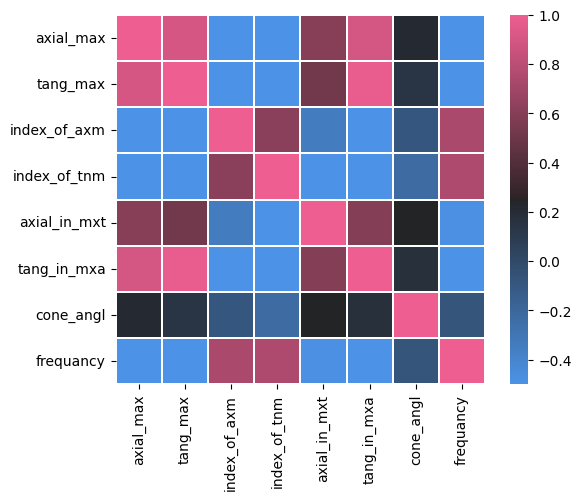

In [46]:
# check of independense

# Lets build something to visualise undepandance od data features
corr = df.iloc[:,:].corr(method='pearson')
cmap = sns.diverging_palette(250, 354, 80, 60, center = 'dark', as_cmap = True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

<Axes: >

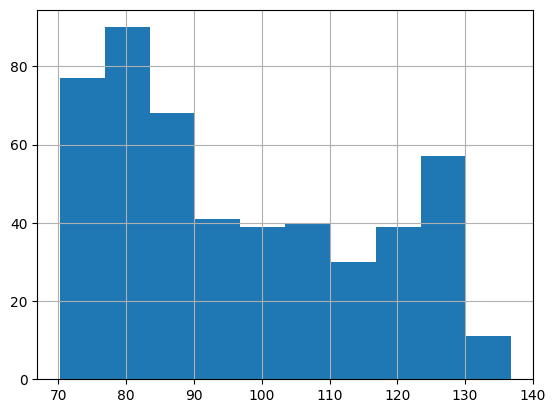

In [47]:
df['frequancy'].hist()

2. Let's try with not full data

In [48]:
df_first_modl = df[['tang_max', 'tang_in_mxa', 'frequancy']]

print(df_first_modl.shape)

(492, 3)


In [49]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device


In [50]:
# Define a Dataset
def dataframe_to_arrays(input_cols, output_cols, dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

'''
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)
'''

# Define a Dataset
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.astype('float32'))
        self.y = torch.from_numpy(y.astype('float32'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)

col = df_first_modl.columns
inputs_array, targets_array = dataframe_to_arrays(col[0:1], col[2], df_first_modl)
dataset = RegressionDataset(inputs_array, targets_array)

In [51]:
# Like thrain/test/split ?
train_dataset, test_dataset = random_split(dataset, lengths=[0.8, 0.2])

# Create DataLoaders ? For what ?
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True
)

In [52]:
# Define Linear Regression Class
class LinearRegressionSimple(nn.Module):
    def __init__(self, in_features=1, out_features=1):
        super().__init__()
        self.linear = nn.Linear(
            in_features=in_features, 
            out_features=out_features
            )

    def forward(self, x):
        return self.linear(x)

# Another regresion model
# That's Multiple regression model
class MultipleRegression(nn.Module):
    
    def __init__(self, n_weight:int):
        super(MultipleRegression, self).__init__()
        """Initializing a Multiple regression model of the form:
        
    
        Args:
          n_weight (int): number of weigths
  
        """
        self.w = torch.randn(size =(n_weight,1), dtype=torch.double, 
                             requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def forward(self, X:torch.Tensor):
        """Forward pass for
        y = X * w.T + b

        Args:
          X (torch.Tensor): 2D tensor of observations x features

        Returns:
          torch.Tensor: model predictions
        """
        assert isinstance(X, torch.Tensor)
        prediction = X @ self.w + self.b
        return prediction

3. Train with linear regresion model, to see the base result

In [53]:
model = LinearRegressionSimple()

# Adding Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001)

# Defining our device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up lists to track losses
train_losses = []
val_losses = []

# Defining a Training Function
def train(model, train_loader, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = train_loss/len(train_loader)
    print(f'Epoch [{epoch + 1:03}/{num_epochs:03}] | Train Loss: {avg_loss:.4f}')
    train_losses.append(train_loss/len(train_loader))

# Defining a Validation Function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_loss:.4f}')
    val_losses.append(avg_loss)

In [54]:
# Running our training loop
num_epochs = 30
model.to(device)
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, epoch, num_epochs)
    validate(model, test_loader, criterion, device)

Epoch [001/030] | Train Loss: 2897.6640
Validation Loss: 141.1249
Epoch [002/030] | Train Loss: 90.8117
Validation Loss: 70.2634
Epoch [003/030] | Train Loss: 69.6964
Validation Loss: 70.5186
Epoch [004/030] | Train Loss: 74.4944
Validation Loss: 73.7817


Epoch [005/030] | Train Loss: 70.8323
Validation Loss: 72.5546
Epoch [006/030] | Train Loss: 75.4238
Validation Loss: 77.4766
Epoch [007/030] | Train Loss: 67.3684
Validation Loss: 71.9339
Epoch [008/030] | Train Loss: 72.1778
Validation Loss: 72.2922
Epoch [009/030] | Train Loss: 71.3176
Validation Loss: 75.4186
Epoch [010/030] | Train Loss: 68.0963
Validation Loss: 70.7673
Epoch [011/030] | Train Loss: 69.3457
Validation Loss: 73.0337
Epoch [012/030] | Train Loss: 71.3709
Validation Loss: 74.4803
Epoch [013/030] | Train Loss: 67.0981
Validation Loss: 72.7448
Epoch [014/030] | Train Loss: 77.2520
Validation Loss: 69.4070
Epoch [015/030] | Train Loss: 80.6005
Validation Loss: 68.0768
Epoch [016/030] | Train Loss: 69.8930
Validation Loss: 73.7655
Epoch [017/030] | Train Loss: 71.4730
Validation Loss: 76.6867
Epoch [018/030] | Train Loss: 78.1640
Validation Loss: 74.7834
Epoch [019/030] | Train Loss: 68.5340
Validation Loss: 74.2822
Epoch [020/030] | Train Loss: 72.4292
Validation Loss: 

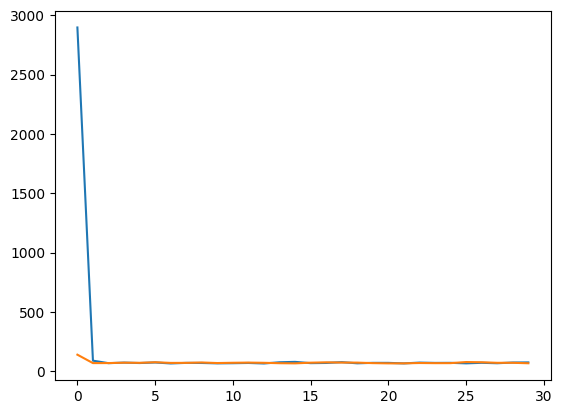

In [55]:
# Creating a Line Chart of Our Data
plt.plot(range(len(train_losses)), train_losses, val_losses)

4. Let's teach Multiple Regresion to compare results

In [56]:
'''
mymodel = MultipleRegression(n_weight = 3)
#myoptimizer = torch.optim.SGD(params = [mymodel.b,mymodel.w], lr = 1e-9, momentum =0.9)
myoptimizer = torch.optim.Adam([mymodel.b, mymodel.w], lr = 0.005)
X = inputs_array
y = targets_array
myMSE = list()
for epoch in tqdm(range(5_000)):
    myoptimizer.zero_grad() # 1. Set gradients to zero
    predicted = mymodel(X) # 2. compute prediction (forward method)
    loss = F.mse_loss(predicted, y.reshape(-1,1)) # 3. compute MSE
    myMSE.append(loss)
    loss.backward() # 4. compute the gradient based on previous
    myoptimizer.step() # 5. myoptimizer updates parameters
    #print(f'epoch = {epoch:02d}, loss = {current_loss}, a = {w}, b = {b}') # 6.


plt.plot(myMSE)
plt.xlabel('Epoch (#)'), plt.ylabel('Mean squared Errors')
'''

"\nmymodel = MultipleRegression(n_weight = 3)\n#myoptimizer = torch.optim.SGD(params = [mymodel.b,mymodel.w], lr = 1e-9, momentum =0.9)\nmyoptimizer = torch.optim.Adam([mymodel.b, mymodel.w], lr = 0.005)\nX = inputs_array\ny = targets_array\nmyMSE = list()\nfor epoch in tqdm(range(5_000)):\n    myoptimizer.zero_grad() # 1. Set gradients to zero\n    predicted = mymodel(X) # 2. compute prediction (forward method)\n    loss = F.mse_loss(predicted, y.reshape(-1,1)) # 3. compute MSE\n    myMSE.append(loss)\n    loss.backward() # 4. compute the gradient based on previous\n    myoptimizer.step() # 5. myoptimizer updates parameters\n    #print(f'epoch = {epoch:02d}, loss = {current_loss}, a = {w}, b = {b}') # 6.\n\n\nplt.plot(myMSE)\nplt.xlabel('Epoch (#)'), plt.ylabel('Mean squared Errors')\n"

In [57]:
input_df = df.drop(columns='frequancy')
targe_df = df['frequancy']
col_inp = input_df.columns

X_train, X_test, y_train, y_test = train_test_split(input_df,
                                                    targe_df,
                                                    test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(393, 7) (393,)
(99, 7) (99,)


In [58]:
# Convert the data to torch tensors
train_x = torch.tensor(X_train.values, dtype=torch.float)
test_x = torch.tensor(X_test.values, dtype=torch.float)

train_y = torch.tensor(y_train.values, dtype=torch.float)
test_y = torch.tensor(y_test.values, dtype=torch.float)

train_data = data_utils.TensorDataset(train_x, train_y)
train_loader = data_utils.DataLoader(train_data, batch_size=100, shuffle=True)
features_batch, target_batch = next(iter(train_loader))

In [59]:
# Define some parameters
input_shape = train_x.shape[1]
output_shape = 1
hidden_layers = 10
loss_func = torch.nn.MSELoss()

# Define the model
model = torch.nn.Sequential(torch.nn.Linear(input_shape, hidden_layers),
                            #torch.nn.Linear(hidden_layers, hidden_layers),
                            #torch.nn.Linear(hidden_layers, hidden_layers),
                            #torch.nn.Linear(hidden_layers, hidden_layers),
                            torch.nn.Linear(hidden_layers, output_shape),
                            )

#  Visualize the model using `hiddenlayer` package !!!
#  hl.build_graph(model, torch.zeros([10, input_shape]))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

total_steps = len(train_loader)
num_epochs = 20000
for epoch in range(num_epochs + 1):
  for i, (inputs, target) in enumerate(train_loader):
    # here features and target are one batch of the training data like explained above

    # perform a forward pass
    output = model(inputs)
    # calculate the loss
    loss = loss_func(output, target)

    # make the gradients zero
    optimizer.zero_grad()

    # backpropogate
    loss.backward()

    # update the parameters. Notice how simple it is here
    optimizer.step()

    if epoch % 2000 == 0:
      print("Epoch [{}/{}]: Step[{}/{}], Loss:{:.4f}"
              .format(epoch+1, num_epochs, i+1, total_steps, loss.item()))

Epoch [1/20000]: Step[1/4], Loss:10818.0020
Epoch [1/20000]: Step[2/4], Loss:10857.1748
Epoch [1/20000]: Step[3/4], Loss:10549.1436
Epoch [1/20000]: Step[4/4], Loss:10055.0518
Epoch [2001/20000]: Step[1/4], Loss:310.0598
Epoch [2001/20000]: Step[2/4], Loss:398.9691
Epoch [2001/20000]: Step[3/4], Loss:392.6972
Epoch [2001/20000]: Step[4/4], Loss:382.9965
Epoch [4001/20000]: Step[1/4], Loss:388.4227
Epoch [4001/20000]: Step[2/4], Loss:343.0497
Epoch [4001/20000]: Step[3/4], Loss:407.3942
Epoch [4001/20000]: Step[4/4], Loss:326.5234
Epoch [6001/20000]: Step[1/4], Loss:370.6558
Epoch [6001/20000]: Step[2/4], Loss:352.5360
Epoch [6001/20000]: Step[3/4], Loss:390.3402
Epoch [6001/20000]: Step[4/4], Loss:344.1386
Epoch [8001/20000]: Step[1/4], Loss:373.0721
Epoch [8001/20000]: Step[2/4], Loss:348.7442
Epoch [8001/20000]: Step[3/4], Loss:359.2443
Epoch [8001/20000]: Step[4/4], Loss:376.0034
Epoch [10001/20000]: Step[1/4], Loss:369.7084
Epoch [10001/20000]: Step[2/4], Loss:356.5525
Epoch [10001

In [60]:
model.eval()

# Predict on the test set
with torch.no_grad():
  # Anything inside `torch.no_grad()`
  # puts the `requires_grad` property to False.
  y_pred = model(test_x)

# convert the tensor to a numpy array
y_pred = y_pred.detach().numpy()
print(y_pred.shape)

print(mean_absolute_percentage_error(y_test, y_pred))

(99, 1)
0.17375557087799928


In [61]:
class MLPRegressor(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x



'\nfrom torchviz import make_dot\n\nbatch = next(iter(target))\nyhat = model(batch.text)\n\nmake_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")\n'